# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 224X224
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: tfimm transformer
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-4
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
!pip install -q tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.64 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
from tqdm import tqdm

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import losses, optimizers, Model, layers

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image


from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import tensorflow.keras.backend as K, gc


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

2024-09-18 08:30:13.678959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 08:30:13.679017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 08:30:13.680610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using 2 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything(42)

In [5]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [6]:
USE_CXR = True

In [7]:
if USE_CXR: 
    df = pd.read_csv('/kaggle/input/cxr-nih-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*', '*'))}    
    
    df['path'] = df['Image Index'].map(tmp)

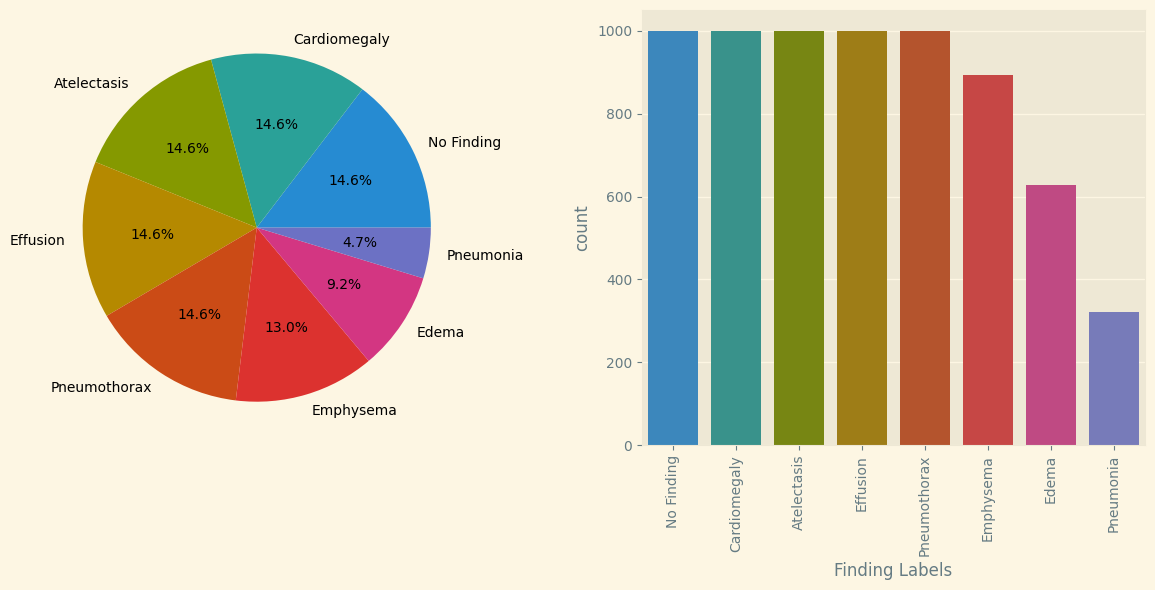

In [8]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [10]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-df['Finding Labels'].nunique():].tolist()

In [11]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [12]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.preprocess != None: X = self.preprocess(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),224,224,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((224,224), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
            
            X[j,:,:] = img
            y[j,] = row[TARGET]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),            
            
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0) 
        
        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:  
                j = idx[i]
            
                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)
        
        return img_batch


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build Vit Model</b></div>

In [14]:
!pip install -q tfimm

import tfimm

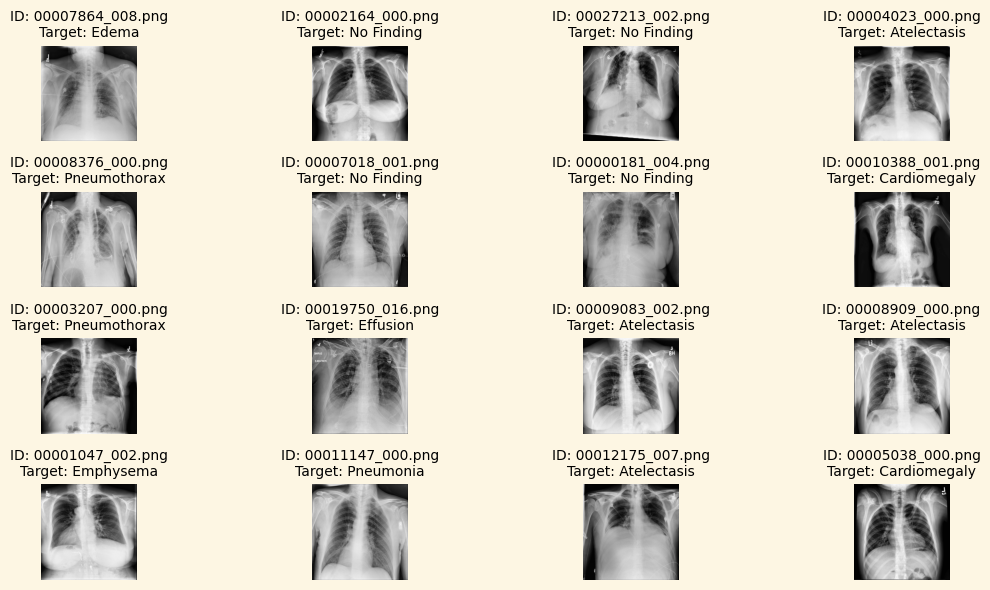

In [15]:
ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Patch Images 

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self,images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
             images=images,
             sizes=[1,self.patch_size,self.patch_size,1],
             strides = [1, self.patch_size, self.patch_size, 1],
             rates = [1,1,1,1],
             padding = 'VALID'
        )
        # patches shape=(batch size,number of patches in height,number of patches in width,patch size×patch size×channels)
        patch_dims = patches.shape[-1]
        
        # patches shape=(batch_size, number of patches, patch * patch * channel)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196


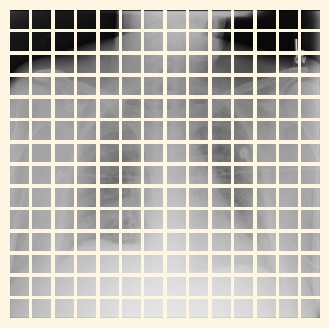

In [17]:
image_size = 224
patch_size = 16

path = df_train.iloc[0]['path']
img = Image.open(path).convert('RGB')
img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
img = np.array(img)
img = np.expand_dims(img, axis=0)

patches = Patches(patch_size)(img)

print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    plt.subplot(n,n,i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

In [18]:
preprocessing = tfimm.create_preprocessing('cait_s24_224', dtype="float32")

In [19]:
def build_model():
    inp = layers.Input(shape=(224,224,3)) 
    
    base_model =  tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0)
    
    # Freezing Layers
    for layer in base_model.layers[:len(base_model.layers)//10]:
        layer.trainable = False
    
    # Output
    x = base_model(inp)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-5)
    label_weights = [1.0] * 8
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [20]:
from tensorflow.keras.utils import plot_model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 cait_s24_224 (CaiT)         (None, 384)               46531200  
                                                                 
 dense (Dense)               (None, 8)                 3080      
                                                                 
Total params: 46534280 (177.51 MB)
Trainable params: 44463608 (169.62 MB)
Non-trainable params: 2070672 (7.90 MB)
_________________________________________________________________


In [21]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

In [23]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=preprocessing)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=preprocessing)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'Vit_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])
        
    else:
        model.load_weights(f'{LOAD_MODELS_FROM}Vit_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
  
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 4378, valid size 1095
#########################
Epoch 1/10


I0000 00:00:1726648433.099449      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 [==============================] - 426s 873ms/step - loss: 0.4143 - auc: 0.5736 - val_loss: 0.4067 - val_auc: 0.5946 - lr: 1.0000e-05
Epoch 2/10
274/274 [==============================] - 167s 610ms/step - loss: 0.4045 - auc: 0.6104 - val_loss: 0.4054 - val_auc: 0.6080 - lr: 1.0000e-05
Epoch 3/10
274/274 [==============================] - 168s 611ms/step - loss: 0.4020 - auc: 0.6282 - val_loss: 0.4046 - val_auc: 0.6203 - lr: 1.0000e-05
Epoch 4/10
274/274 [==============================] - ETA: 0s - loss: 0.4028 - auc: 0.6255
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
274/274 [==============================] - 168s 613ms/step - loss: 0.4028 - auc: 0.6255 - val_loss: 0.4017 - val_auc: 0.6246 - lr: 1.0000e-05
Epoch 5/10
274/274 [==============================] - 167s 610ms/step - loss: 0.3995 - auc: 0.6428 - val_loss: 0.4003 - val_auc: 0.6335 - lr: 1.0000e-06
Epoch 6/10
274/274 [==============================] - ETA: 0s - loss: 0.3993 - auc: 0.6445

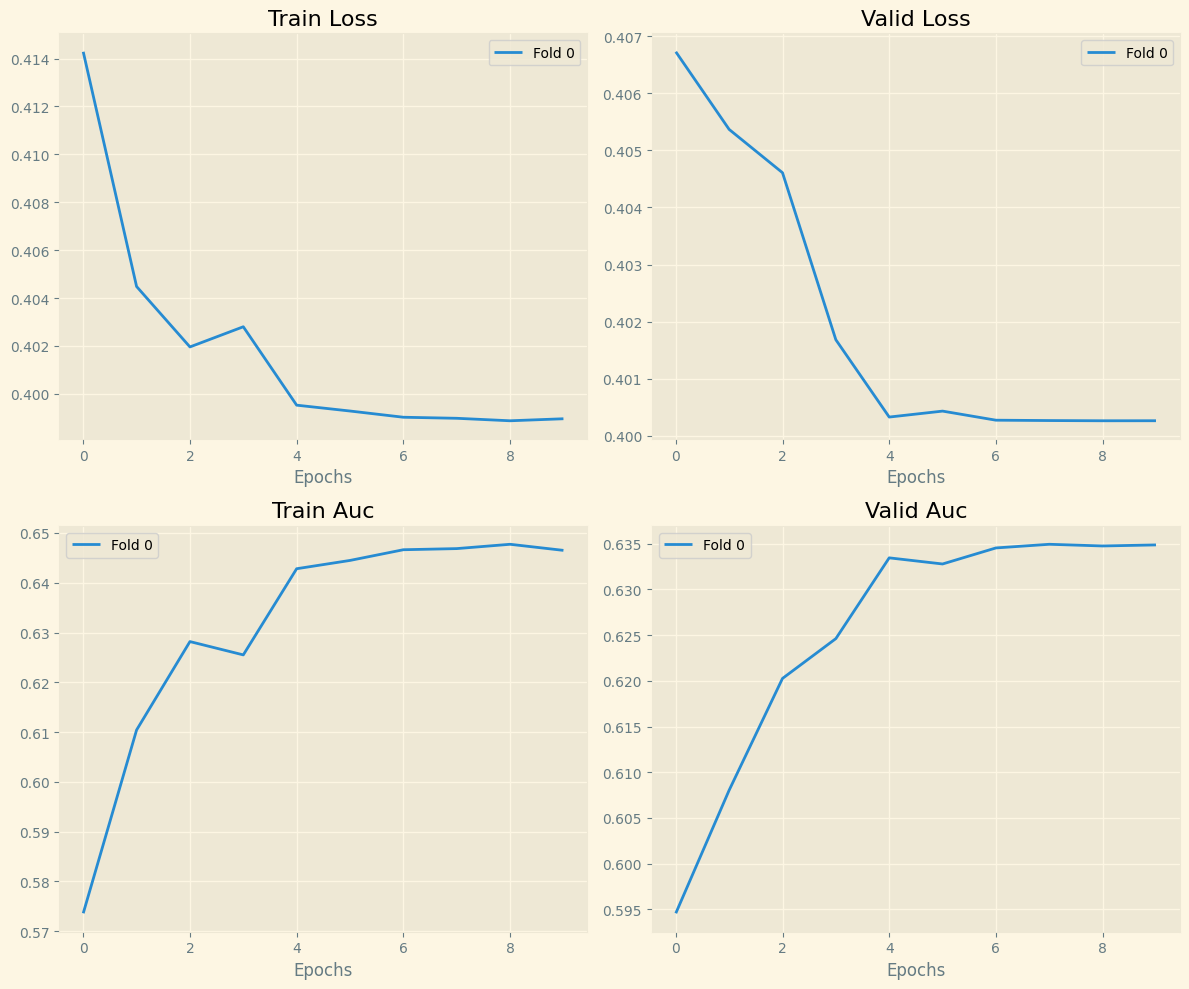

In [24]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Train Auc')
    for fold, i in enumerate(all_history['Train Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Valid Auc')
    for fold, i in enumerate(all_history['Valid Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

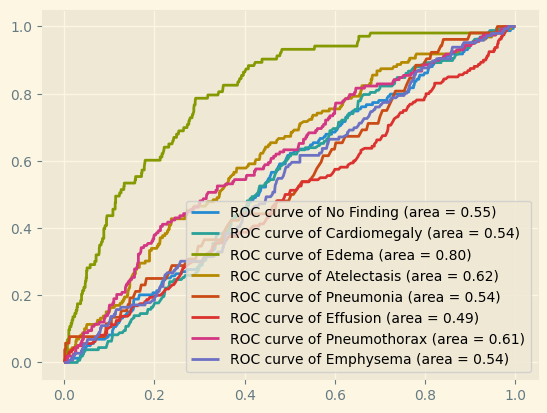

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [26]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.5868060673649529


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Inference</b></div>

In [27]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=preprocessing)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Vit_f{i}.weights.h5')
    else: 
        model.load_weights(f'Vit_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

Fold 1
22/22 [==============================] - 68s 3s/step
AUC for Test Set = 0.5923580013077179


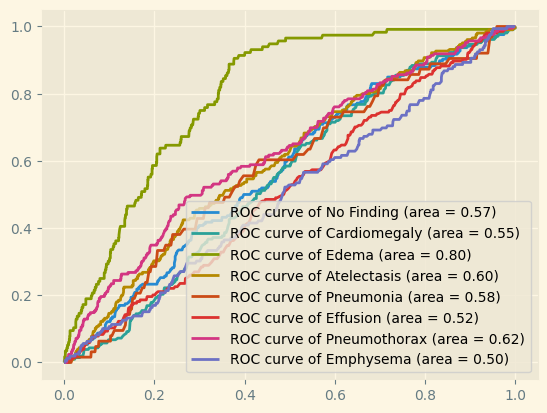

In [28]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()